## Amazon Sales Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('D:\\Python\\Amazon Sales - Sentiment Analysis\\raw_data\\amazon.csv')
df.head(10)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,399,"1,099",64%,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,199,349,43%,4,43994.0,"Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,199,"1,899",90%,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,329,699,53%,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,154,399,61%,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...
5,B08Y1TFSP6,pTron Solero TB301 3A Type-C Data and Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,149,"1,000",85%,3.9,24871.0,Fast Charging & Data Sync: Solero TB301 Type-C...,"AEQ2YMXSZWEOHK2EHTNLOS56YTZQ,AGRVINWECNY7323CW...","Jayesh,Rajesh k.,Soopy,amazon customer,Aman,Sh...","R7S8ANNSDPR40,R3CLZFLHVJU26P,RFF7U7MPQFUGR,R1M...","It's pretty good,Average quality,very good and...","It's a good product.,Like,Very good item stron...",https://m.media-amazon.com/images/I/31wOPjcSxl...,https://www.amazon.in/Solero-TB301-Charging-48...
6,B08WRWPM22,"boAt Micro USB 55 Tangle-free, Sturdy Micro US...",Computers&Accessories|Accessories&Peripherals|...,176.63,499,65%,4.1,15188.0,It Ensures High Speed Transmission And Chargin...,"AG7C6DAADCTRQJG2BRS3RIKDT52Q,AFU7BOMPVJ7Q3TTA4...","Vivek kumar,Amazon Customer,SARTHAK,Chiranjeev...","R8E73K2KWJRDS,RSD0JTIIWQQL8,R64CRSTE9SLW1,R2FR...","Long durable.,good,Does not charge Lenovo m8 t...",Build quality is good and it is comes with 2 y...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.ama

#### Data Cleaning

In [3]:
# Check column names
df.columns

Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')

In [4]:
# Check no of rows and columns
df.shape

(1465, 16)

In [5]:
# Chcek data types
df.dtypes

product_id              object
product_name            object
category                object
discounted_price        object
actual_price            object
discount_percentage     object
rating                  object
rating_count           float64
about_product           object
user_id                 object
user_name               object
review_id               object
review_title            object
review_content          object
img_link                object
product_link            object
dtype: object

In [6]:
# Change the data type of discounted price and actual price
df['discounted_price'] = df['discounted_price'].str.replace(',', '').astype(float)
df['actual_price'] = df['actual_price'].str.replace(',', '').astype(float)

In [7]:
# Change the data type and values in Discount percentage
df['discount_percentage'] = df['discount_percentage'].str.replace('%', '').astype(float)
df['discount_percentage'] = df['discount_percentage']/100
df['discount_percentage']

0       0.64
1       0.43
2       0.90
3       0.53
4       0.61
        ... 
1460    0.59
1461    0.25
1462    0.28
1463    0.26
1464    0.22
Name: discount_percentage, Length: 1465, dtype: float64

In [8]:
# Identify unwanted string in the rating column
df['rating'].value_counts()

rating
4.1    244
4.3    230
4.2    228
4      181
3.9    123
4.4    123
3.8     86
4.5     75
3.7     42
3.6     35
3.5     26
4.6     17
3.3     16
3.4     10
4.7      6
3        4
3.1      4
5        3
4.8      3
3.2      2
2.8      2
2.3      1
|        1
2        1
2.6      1
2.9      1
Name: count, dtype: int64

In [9]:
# Inspect the rows with unwanted string in the rating column
df.query('rating == "|"')

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
1279,B08L12N5H1,Eureka Forbes car Vac 100 Watts Powerful Sucti...,"Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle...",2099.0,2499.0,0.16,|,992.0,No Installation is provided for this product|1...,"AGTDSNT2FKVYEPDPXAA673AIS44A,AER2XFSWNN4LAUCJ5...","Divya,Dr Nefario,Deekshith,Preeti,Prasanth R,P...","R2KKTKM4M9RDVJ,R1O692MZOBTE79,R2WRSEWL56SOS4,R...","Decent product,doesn't pick up sand,Ok ok,Must...","Does the job well,doesn't work on sand. though...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Eureka-Forbes-Vacuum-Cle...


I've visited the amazon website to get the rating and found that this product has a rating of 3.9. So, I've replaced the rating value with 3.9.

In [10]:
# Changing Rating column data type
df['rating'] = df['rating'].str.replace('|', '3.9').astype(float)

In [11]:
# Check for duplicates
df.duplicated().sum()

0

In [12]:
# Check missing values
df.isnull().sum()

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64

In [13]:
# Create a new dataframe with selected columns
df1 = df[['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']].copy()

In [14]:
# Split the strings in category column
catsplit = df1['category'].str.split('|', expand=True)
catsplit

,0,1,2,3,4,5,6
0,Computers&Accessories,Accessories&Peripherals,Cables&Accessories,Cables,USBCables,None,None
1,Computers&Accessories,Accessories&Peripherals,Cables&Accessories,Cables,USBCables,None,None
2,Computers&Accessories,Accessories&Peripherals,Cables&Accessories,Cables,USBCables,None,None
3,Computers&Accessories,Accessories&Peripherals,Cables&Accessories,Cables,USBCables,None,None
4,Computers&Accessories,Accessories&Peripherals,Cables&Accessories,Cables,USBCables,None,None
...,...,...,...,...,...,...,...
1460,Home&Kitchen,Kitchen&HomeAppliances,WaterPurifiers&Accessories,WaterPurifierAccessories,None,None,None
1461,Home&Kitchen,Kitchen&HomeAppliances,SmallKitchenAppliances,Rice&PastaCookers,None,None,None
1462,Home&Kitchen,"Heating,Cooling&AirQuality",RoomHeaters,HeatConvectors,None,None,None
1463,Home&Kitchen,"Heating,Cooling&AirQuality",Fans,ExhaustFans,None,None,None


In [15]:
# Rename the category columns
catsplit = catsplit.rename(columns={0: 'category1', 1: 'category2', 2: 'category3'})

In [16]:
# Adding the categories to the main dataframe
df1['category_1'] = catsplit['category1']
df1['category_2'] = catsplit['category2']

# Drop the original category column
df1 = df1.drop('category', axis=1)

# Check the new dataframe
df1.head()

,product_id,product_name,discounted_price,actual_price,discount_percentage,rating,rating_count,category_1,category_2
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,399.0,1099.0,0.64,4.2,24269.0,Computers&Accessories,Accessories&Peripherals
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,199.0,349.0,0.43,4.0,43994.0,Computers&Accessories,Accessories&Peripherals
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,199.0,1899.0,0.90,3.9,7928.0,Computers&Accessories,Accessories&Peripherals
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,329.0,699.0,0.53,4.2,94363.0,Computers&Accessories,Accessories&Peripherals
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,154.0,399.0,0.61,4.2,16905.0,Computers&Accessories,Accessories&Peripherals


In [17]:
# Check category 1 unique values
df1['category_1'].value_counts()

category_1
Electronics              526
Computers&Accessories    453
Home&Kitchen             448
OfficeProducts            31
MusicalInstruments         2
HomeImprovement            2
Toys&Games                 1
Car&Motorbike              1
Health&PersonalCare        1
Name: count, dtype: int64

In [18]:
# Fix the strings in category 1 column
df1['category_1'] = df1['category_1'].str.replace('&', ' & ')
df1['category_1'] = df1['category_1'].str.replace('OfficeProducts', 'Office Products')
df1['category_1'] = df1['category_1'].str.replace('MusicalInstruments', 'Musical Instruments')
df1['category_1'] = df1['category_1'].str.replace('HomeImprovement', 'Home Improvement')

In [19]:
# Check category 2 unique values
df1['category_2'].value_counts()

category_2
Accessories&Peripherals                    381
Kitchen&HomeAppliances                     308
HomeTheater,TV&Video                       162
Mobiles&Accessories                        161
Heating,Cooling&AirQuality                 116
WearableTechnology                          76
Headphones,Earbuds&Accessories              66
NetworkingDevices                           34
OfficePaperProducts                         27
ExternalDevices&DataStorage                 18
Cameras&Photography                         16
HomeStorage&Organization                    16
HomeAudio                                   16
GeneralPurposeBatteries&BatteryChargers     14
Accessories                                 14
Printers,Inks&Accessories                   11
CraftMaterials                               7
Components                                   5
OfficeElectronics                            4
Electrical                                   2
Monitors                                     2
Mi

In [20]:
# Fix the strings in category 2 column
df1['category_2'] = df1['category_2'].str.replace('&', ' & ')
df1['category_2'] = df1['category_2'].str.replace(',', ', ')
df1['category_2'] = df1['category_2'].str.replace('HomeAppliances', 'Home Appliances')
df1['category_2'] = df1['category_2'].str.replace('AirQuality', 'Air Quality')
df1['category_2'] = df1['category_2'].str.replace('WearableTechnology', 'Wearable Technology')
df1['category_2'] = df1['category_2'].str.replace('NetworkingDevices', 'Networking Devices')
df1['category_2'] = df1['category_2'].str.replace('OfficeElectronics', 'Office Electronics')
df1['category_2'] = df1['category_2'].str.replace('OfficePaperProducts', 'Office Paper Products')
df1['category_2'] = df1['category_2'].str.replace('ExternalDevices', 'External Devices')
df1['category_2'] = df1['category_2'].str.replace('DataStorage', 'Data Storage')
df1['category_2'] = df1['category_2'].str.replace('HomeStorage', 'Home Storage')
df1['category_2'] = df1['category_2'].str.replace('HomeAudio', 'Home Audio')
df1['category_2'] = df1['category_2'].str.replace('GeneralPurposeBatteries', 'General Purpose Batteries')
df1['category_2'] = df1['category_2'].str.replace('BatteryChargers', 'Battery Chargers')
df1['category_2'] = df1['category_2'].str.replace('CraftMaterials', 'Craft Materials')
df1['category_2'] = df1['category_2'].str.replace('PowerAccessories', 'Power Accessories')
df1['category_2'] = df1['category_2'].str.replace('CarAccessories', 'Car Accessories')
df1['category_2'] = df1['category_2'].str.replace('HomeMedicalSupplies', 'Home Medical Supplies')
df1['category_2'] = df1['category_2'].str.replace('HomeTheater', 'Home Theater')

In [21]:
# Removing Whitespaces from product id
df1['product_id'].str.strip()

0       B07JW9H4J1
1       B098NS6PVG
2       B096MSW6CT
3       B08HDJ86NZ
4       B08CF3B7N1
           ...    
1460    B08L7J3T31
1461    B01M6453MB
1462    B009P2LIL4
1463    B00J5DYCCA
1464    B01486F4G6
Name: product_id, Length: 1465, dtype: object

In [22]:
# Create categories for rankings
rating_score = []

for score in df1['rating']:
    if score >= 4.5:
        rating_score.append('Excellent')
    elif score >= 4.0:
        rating_score.append('Good')
    elif score >= 3.5:
        rating_score.append('Above Average')
    elif score >= 3.0:
        rating_score.append('Average')
    else:
        rating_score.append('Poor')

In [23]:
# Create a new column and changing the data type
df1['rating_score'] = rating_score
df1['rating_score'] = df1['rating_score'].astype('category')

In [24]:
# Reorder the categories
df1['rating_score'] = df1['rating_score'].cat.reorder_categories(['Excellent', 'Good', 'Above Average', 'Average', 'Poor'], ordered=True)

In [25]:
# Creating difference of price column between actual and discounted price
df1['difference_price'] = df1['actual_price'] - df1['discounted_price']

In [26]:
# Result after cleaning
df1.head()

,product_id,product_name,discounted_price,actual_price,discount_percentage,rating,rating_count,category_1,category_2,rating_score,difference_price
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,399.0,1099.0,0.64,4.2,24269.0,Computers & Accessories,Accessories & Peripherals,Good,700.0
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,199.0,349.0,0.43,4.0,43994.0,Computers & Accessories,Accessories & Peripherals,Good,150.0
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,199.0,1899.0,0.90,3.9,7928.0,Computers & Accessories,Accessories & Peripherals,Above Average,1700.0
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,329.0,699.0,0.53,4.2,94363.0,Computers & Accessories,Accessories & Peripherals,Good,370.0
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,154.0,399.0,0.61,4.2,16905.0,Computers & Accessories,Accessories & Peripherals,Good,245.0


In [27]:
# Subsetting Reviewers Identifications
reviewers = df[['user_id', 'user_name']]
reviewers

,user_id,user_name
0,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp..."
1,"AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac..."
2,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal..."
3,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ..."
4,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK..."
...,...,...
1460,"AHITFY6AHALOFOHOZEOC6XBP4FEA,AFRABBODZJZQB6Z4U...","Prabha ds,Raghuram bk,Real Deal,Amazon Custome..."
1461,"AFG5FM3NEMOL6BNFRV2NK5FNJCHQ,AGEINTRN6Z563RMLH...","Manu Bhai,Naveenpittu,Evatira Sangma,JAGANNADH..."
1462,"AGVPWCMAHYQWJOQKMUJN4DW3KM5Q,AF4Q3E66MY4SR7YQZ...","Nehal Desai,Danish Parwez,Amazon Customer,Amaz..."
1463,"AF2JQCLSCY3QJATWUNNHUSVUPNQQ,AFDMLUXC5LS5RXDJS...","Shubham Dubey,E.GURUBARAN,Mayank S.,eusuf khan..."


In [28]:
# Split the strings in user_id column
reviewer_id_split = reviewers['user_id'].str.split(',', expand=False)
reviewer_id_split

0       [AG3D6O4STAQKAY2UVGEUV46KN35Q, AHMY5CWJMMK5BJR...
1       [AECPFYFQVRUWC3KGNLJIOREFP5LQ, AGYYVPDD7YG7FYN...
2       [AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA, AESFLDV2PT363T2...
3       [AEWAZDZZJLQUYVOVGBEUKSLXHQ5A, AG5HTSFRRE6NL3M...
4       [AE3Q6KSUK5P75D5HFYHCRAOLODSA, AFUGIFH5ZAFXRDS...
                              ...                        
1460    [AHITFY6AHALOFOHOZEOC6XBP4FEA, AFRABBODZJZQB6Z...
1461    [AFG5FM3NEMOL6BNFRV2NK5FNJCHQ, AGEINTRN6Z563RM...
1462    [AGVPWCMAHYQWJOQKMUJN4DW3KM5Q, AF4Q3E66MY4SR7Y...
1463    [AF2JQCLSCY3QJATWUNNHUSVUPNQQ, AFDMLUXC5LS5RXD...
1464    [AFGW5PT3R6ZAVQR4Y5MWVAKBZAYA, AG7QNJ2SCS5VS5V...
Name: user_id, Length: 1465, dtype: object

In [29]:
# Make user_id to display 1 user_id per row
reviewer_id_exp = reviewer_id_split.explode()
reviewer_id_clean = reviewer_id_exp.reset_index(drop=True)
reviewer_id_clean

0        AG3D6O4STAQKAY2UVGEUV46KN35Q
1        AHMY5CWJMMK5BJRBBSNLYT3ONILA
2        AHCTC6ULH4XB6YHDY6PCH2R772LQ
3        AGYHHIERNXKA6P5T7CZLXKVPT7IQ
4        AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q
                     ...             
11498    AHXCDNSXAESERITAFELQABFVNLCA
11499    AGRZD6CHLCUNOLMMIMIHUCG7PIFA
11500    AFQZVGSOSOJHKFQQMCEI4725QEKQ
11501    AEALVGXXIP46OZVXKRUXSDWZJMEA
11502    AGEFL3AY7YXEFZA4ZJU3LP7K7OJQ
Name: user_id, Length: 11503, dtype: object

In [30]:
# Split the strings in user_name column
reviewer_name_split = reviewers['user_name'].str.split(',', expand=False)
reviewer_name_split

0       [Manav, Adarsh gupta, Sundeep, S.Sayeed Ahmed,...
1       [ArdKn, Nirbhay kumar, Sagar Viswanathan, Asp,...
2       [Kunal, Himanshu, viswanath, sai niharka, saqi...
3       [Omkar dhale, JD, HEMALATHA, Ajwadh a., amar s...
4       [rahuls6099, Swasat Borah, Ajay Wadke, Pranali...
                              ...                        
1460    [Prabha ds, Raghuram bk, Real Deal, Amazon Cus...
1461    [Manu Bhai, Naveenpittu, Evatira Sangma, JAGAN...
1462    [Nehal Desai, Danish Parwez, Amazon Customer, ...
1463    [Shubham Dubey, E.GURUBARAN, Mayank S., eusuf ...
1464    [Rajib, Ajay B, Vikas Kahol, PARDEEP, Anindya ...
Name: user_name, Length: 1465, dtype: object

In [31]:
# Make user_name to display 1 user_name per row
reviewer_name_exp = reviewer_name_split.explode()
reviewer_name_clean = reviewer_name_exp.reset_index(drop=True)
reviewer_name_clean

0                   Manav
1            Adarsh gupta
2                 Sundeep
3          S.Sayeed Ahmed
4          jaspreet singh
               ...       
11510             PARDEEP
11511    Anindya Pramanik
11512         Vikas Singh
11513     Harshada Pimple
11514              Saw a.
Name: user_name, Length: 11515, dtype: object

In [32]:
# Create 2 dataframes for user_id and user_name
reviewer_id_clean = pd.DataFrame(reviewer_id_clean)
reviewer_name_clean = pd.DataFrame(reviewer_name_clean)

In [33]:
# Merge the 2 dataframes
df2 = pd.merge(reviewer_id_clean, reviewer_name_clean, left_index=True, right_index=True)
df2.columns = ['user_id', 'user_name']
df2.head(10)

,user_id,user_name
0,AG3D6O4STAQKAY2UVGEUV46KN35Q,Manav
1,AHMY5CWJMMK5BJRBBSNLYT3ONILA,Adarsh gupta
2,AHCTC6ULH4XB6YHDY6PCH2R772LQ,Sundeep
3,AGYHHIERNXKA6P5T7CZLXKVPT7IQ,S.Sayeed Ahmed
4,AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q,jaspreet singh
5,AENGU523SXMOS7JPDTW52PNNVWGQ,Khaja moin
6,AEQJHCVTNINBS4FKTBGQRQTGTE5Q,Anand
7,AFC3FFC5PKFF5PMA52S3VCHOZ5FQ,S.ARUMUGAM
8,AECPFYFQVRUWC3KGNLJIOREFP5LQ,ArdKn
9,AGYYVPDD7YG7FYNBXNGXZJT525AQ,Nirbhay kumar


#### Data Exploration

In [34]:
sns.set_style('darkgrid')
sns.set_palette('Spectral')

Product Category

In [35]:
# Main category and Sub category
main_sub = df1[['category_1', 'category_2', 'product_id']]
main_sub = main_sub.rename(columns={'category_1': 'Main Category', 'category_2': 'Sub Category', 'product_id': 'Product ID'})
main_sub_piv = pd.pivot_table(main_sub, index=['Main Category', 'Sub Category'], aggfunc='count')
main_sub_piv

Product ID
Main Category           Sub Category                                            
Car & Motorbike         Car Accessories                                        1
Computers & Accessories Accessories & Peripherals                            381
                        Components                                             5
                        External Devices & Data Storage                       18
                        Laptops                                                1
                        Monitors                                               2
                        Networking Devices                                    34
                        Printers, Inks & Accessories                          11
                        Tablets                                                1
Electronics             Accessories                                           14
                        Cameras & Photography                                 16
                        General Purpose Batteries & Battery Chargers          14
                        Headphones, Earbuds & Accessories                     66
                        Home Audio                                            16
                        Home Theater, TV & Video                             162
                        Mobiles & Accessories                                161
                        Power Accessories                                      1
                        Wearable Technology                                   76
Health & PersonalCare   Home Medical Supplies & Equipment                      1
Home & Kitchen          Craft Materials                                        7
                        Heating, Cooling & Air Quality                       116
                        Home Storage & Organization                           16
                        Kitchen & Dining                                       1
                        Kitchen & Home Appliances                            308
Home Improvement        Electrical                                             2
Musical Instruments     Microphones                                            2
Office Products         Office Electronics                                     4
                        Office Paper Products                                 27
Toys & Games            Arts & Crafts                                          1

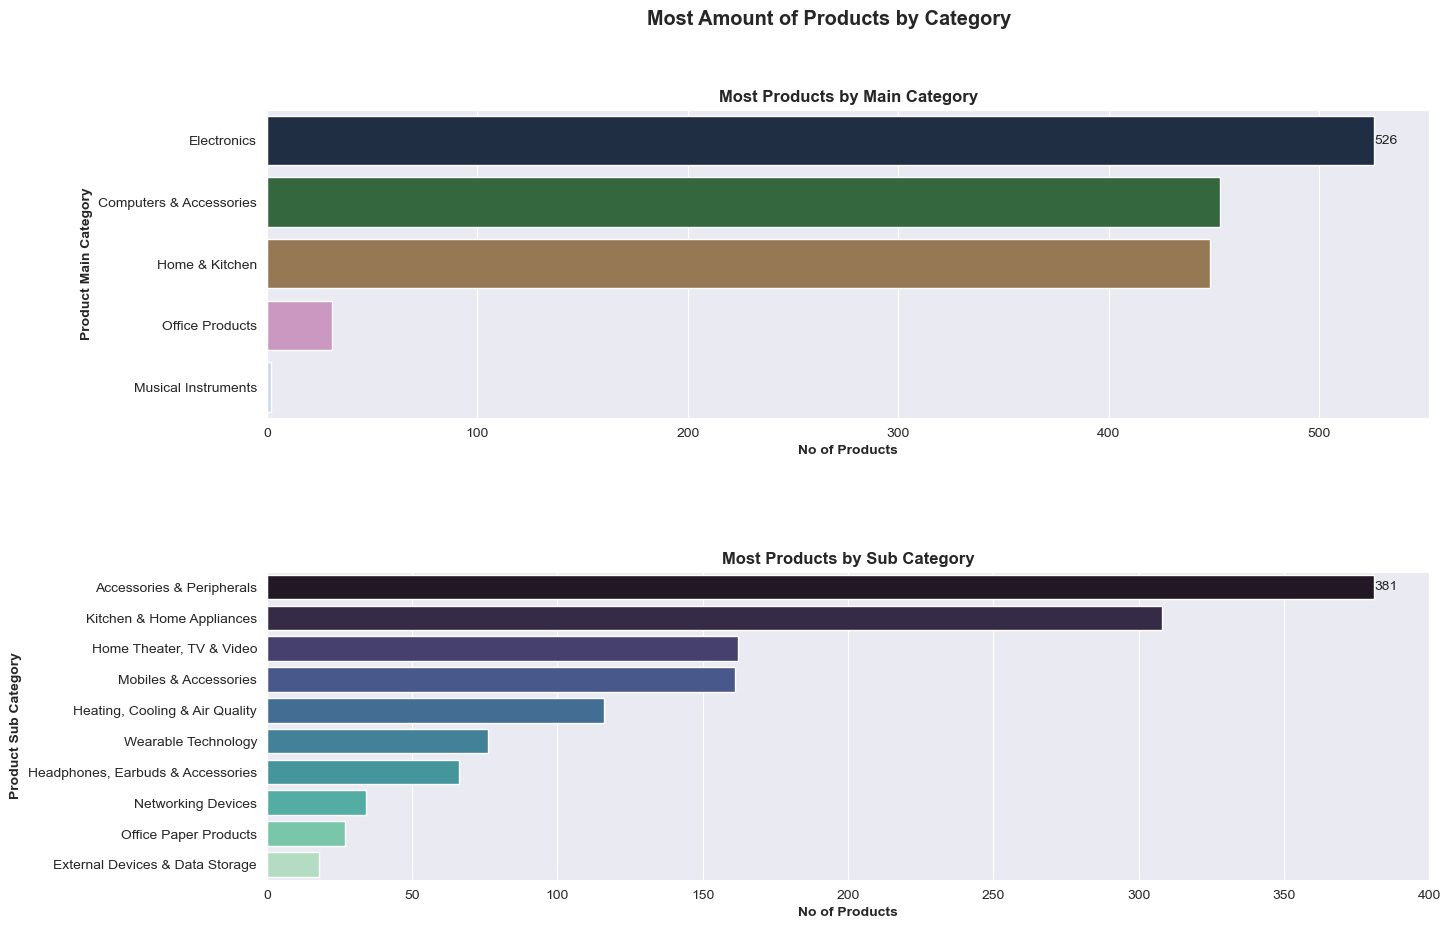

In [36]:
# Most amount of products by category
most_main_items = df1['category_1'].value_counts().head(5).rename_axis('Main Category').reset_index(name='Number of Products')
most_sub_items = df1['category_2'].value_counts().head(10).rename_axis('Sub Category').reset_index(name='Number of Products')

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle('Most Amount of Products by Category', fontweight='bold', size='x-large')

sns.barplot(ax=ax[0], x='Number of Products', y='Main Category', data=most_main_items, palette='cubehelix')
sns.barplot(ax=ax[1], x='Number of Products', y='Sub Category', data=most_sub_items, palette='mako')

plt.subplots_adjust(hspace=0.5)

ax[0].set_xlabel('No of Products', fontweight='bold')
ax[0].set_ylabel('Product Main Category', fontweight='bold')

ax[1].set_xlabel('No of Products', fontweight='bold')
ax[1].set_ylabel('Product Sub Category', fontweight='bold')

ax[0].set_title('Most Products by Main Category', fontweight='bold')
ax[1].set_title('Most Products by Sub Category', fontweight='bold')

ax[0].bar_label(ax[0].containers[0])
ax[1].bar_label(ax[1].containers[0])

plt.show()

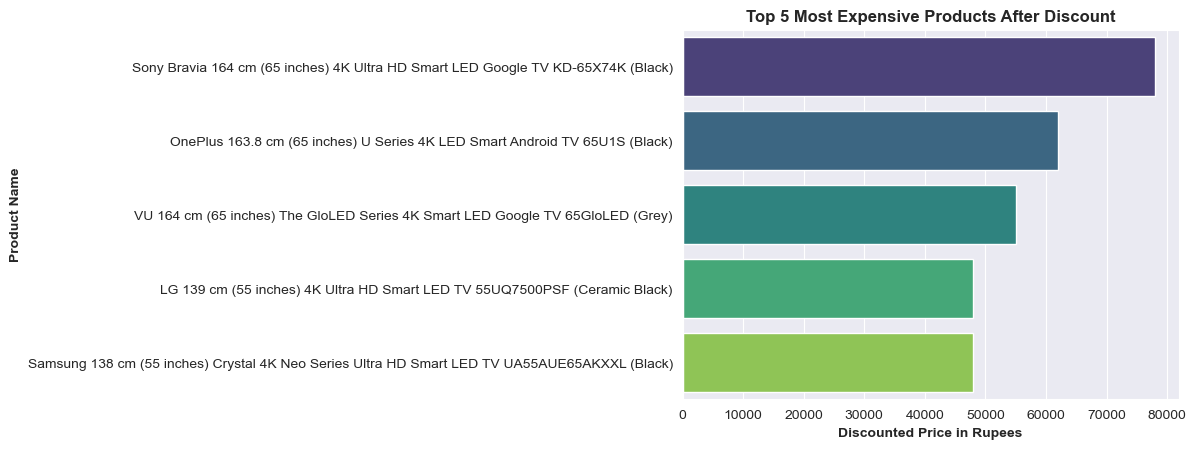

In [37]:
#Top 5 Most Expensive Products After Discount
disc_exp = sns.barplot(data=df1.sort_values('discounted_price', ascending=False).head(5), x='discounted_price', y='product_name', palette='viridis')

disc_exp.set_title('Top 5 Most Expensive Products After Discount', fontweight='bold')
disc_exp.set_xlabel('Discounted Price in Rupees', fontweight='bold')
disc_exp.set_ylabel('Product Name', fontweight='bold')

plt.show()


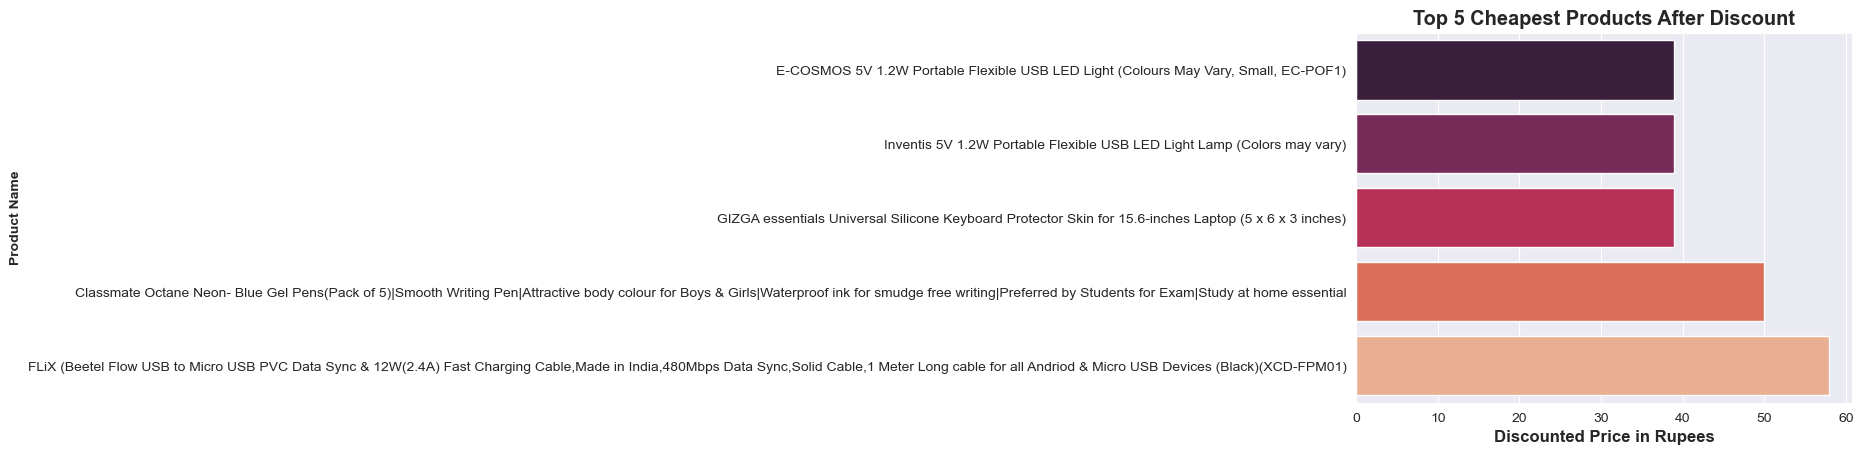

In [40]:
# Top 5 Cheapest Products after Discount
disc_cheap = sns.barplot(data=df1.sort_values('discounted_price').head(5), x='discounted_price', y='product_name', palette='rocket')

disc_cheap.set_title('Top 5 Cheapest Products After Discount', fontweight='bold', size='x-large')
disc_cheap.set_xlabel('Discounted Price in Rupees', fontweight='bold', size='large')
disc_cheap.set_ylabel('Product Name', fontweight='bold')

plt.show()

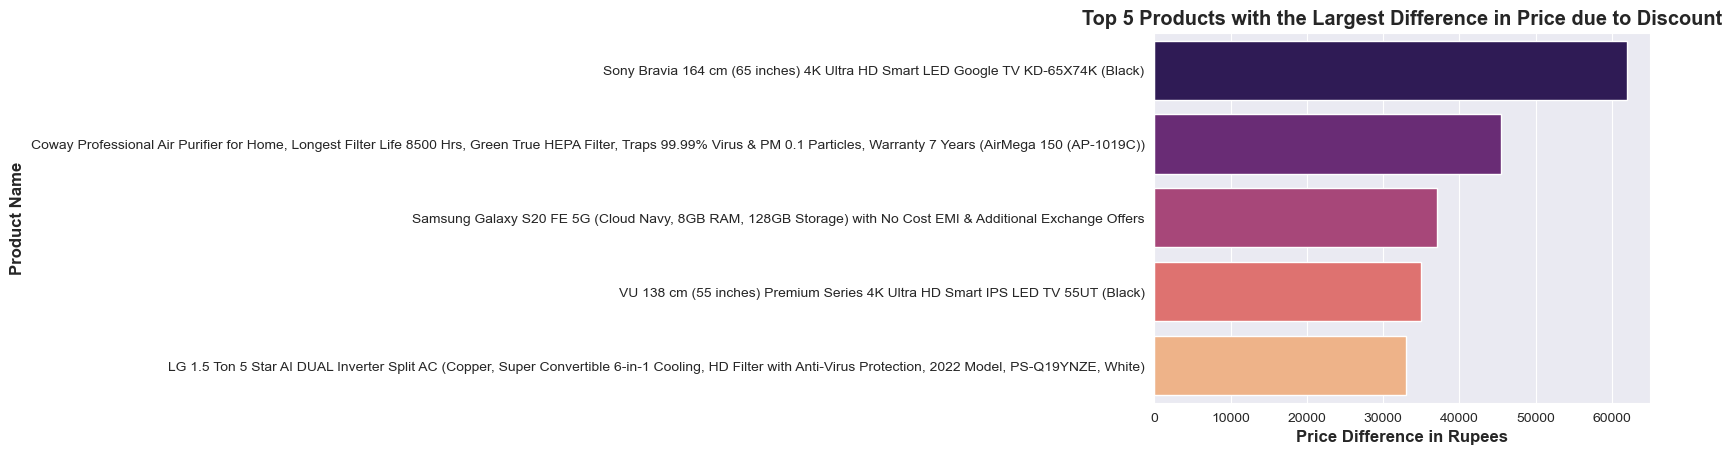

In [42]:
# Top 5 Products with the largest difference in price due to discount
diff_exp = sns.barplot(data=df1.sort_values('difference_price', ascending=False).head(5), x='difference_price', y='product_name', palette='magma')

diff_exp.set_title('Top 5 Products with the Largest Difference in Price due to Discount', fontweight='bold', size='x-large')
diff_exp.set_xlabel('Price Difference in Rupees', fontweight='bold', size='large')
diff_exp.set_ylabel('Product Name', fontweight='bold', size='large')

plt.show()

Correlation between Features

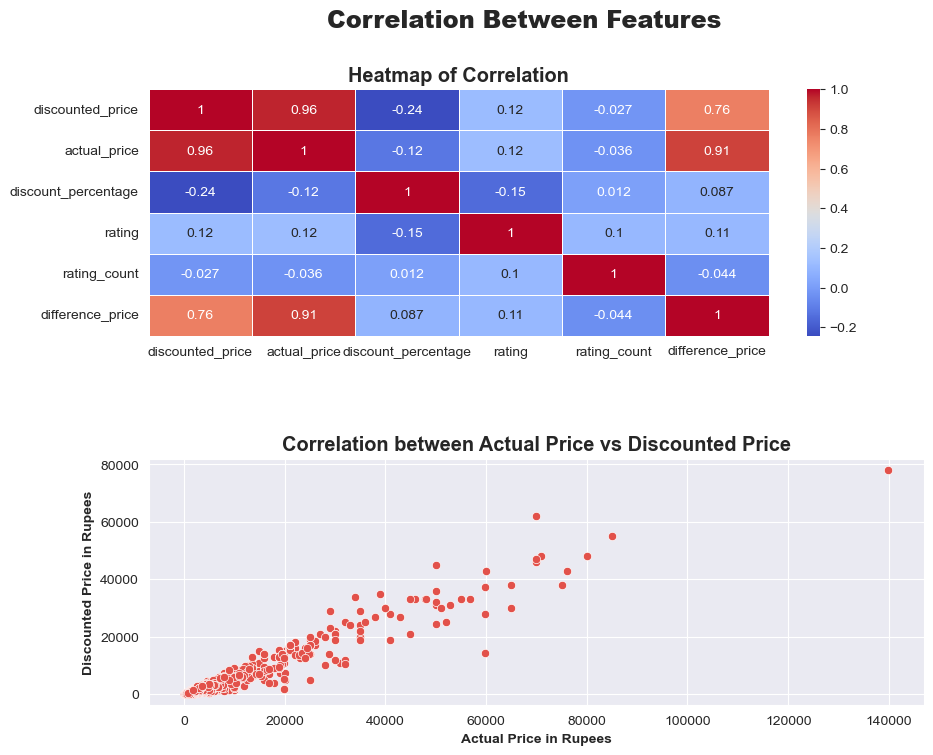

In [45]:
# Heatmap & Correlation between Actual Price & Discounted Price
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('Correlation Between Features', fontweight='heavy', size='xx-large')

sns.heatmap(ax=ax[0], data=df1[['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'difference_price']].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
sns.scatterplot(ax=ax[1], x='actual_price', y='discounted_price', data=df1, palette='rocket_r')

plt.subplots_adjust(hspace=0.5)

ax[0].set_title('Heatmap of Correlation', fontweight='bold', size='x-large')
ax[1].set_title('Correlation between Actual Price vs Discounted Price', fontweight='bold', size='x-large')

ax[1].set_xlabel('Actual Price in Rupees', fontweight='bold')
ax[1].set_ylabel('Discounted Price in Rupees', fontweight='bold')

plt.show()

Product Ratings

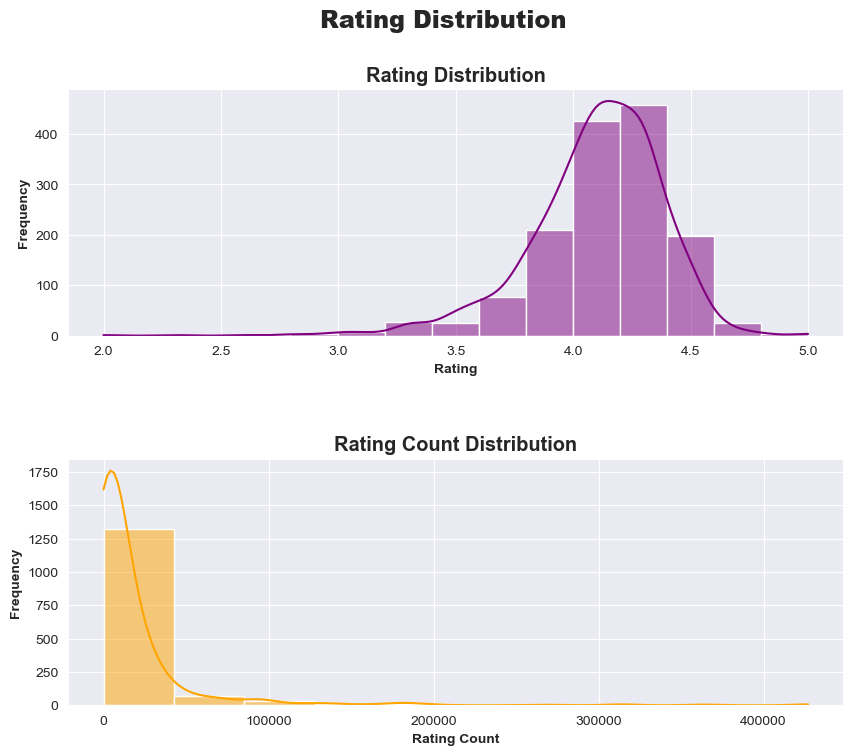

In [47]:
# Rating & Amount of Ratings Distribution
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('Rating Distribution', fontweight='heavy', size='xx-large')

sns.histplot(ax=ax[0], data=df1, x='rating', bins=15, kde=True, color='purple')
sns.histplot(ax=ax[1], data=df1, x='rating_count', bins=10, kde=True, color='orange')

plt.subplots_adjust(hspace=0.5)

ax[0].set_title('Rating Distribution', fontweight='bold', size='x-large')
ax[1].set_title('Rating Count Distribution', fontweight='bold', size='x-large')

ax[0].set_xlabel('Rating', fontweight='bold')
ax[0].set_ylabel('Frequency', fontweight='bold')

ax[1].set_xlabel('Rating Count', fontweight='bold')
ax[1].set_ylabel('Frequency', fontweight='bold')

plt.show()

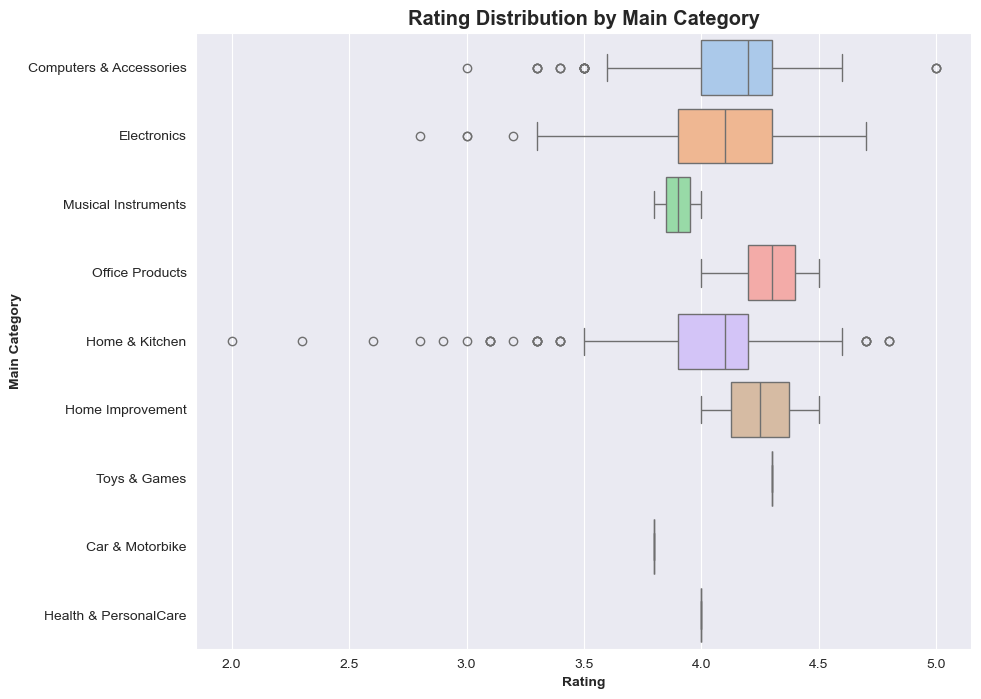

In [48]:
# Rating Distribution by Poduct Main Category
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.boxplot(ax=ax, y='category_1', x='rating', data=df1, palette='pastel')
ax.set_title('Rating Distribution by Main Category', fontweight='bold', size='x-large')
ax.set_xlabel('Rating', fontweight='bold')
ax.set_ylabel('Main Category', fontweight='bold')

plt.show()

Toys & Games, Car & Motorbike, and Health & Personal Care product ratings are around 3.75 - 4.35. All Home Improvement and Office Products have ratings around 4.0 - 4.5.

Computer & Accessories, and Electronics products have ratings in the range of 3.6 - 4.6. Though these categories do have products that have a high rating such as 5.0 and low rating, going down to 2.75.

In [49]:
# Rating of Products based on Rating Category
rate_main_cat = df1.groupby(['category_1', 'rating_score']).agg('count').iloc[:, 1].rename_axis().reset_index(name='Number of Products')
rate_main_cat = rate_main_cat.rename(columns={'category_1': 'Main Category', 'rating_score': 'Rating Category'})

rate_main_cat

,Main Category,Rating Category,Number of Products
0,Car & Motorbike,Excellent,0
1,Car & Motorbike,Good,0
2,Car & Motorbike,Above Average,1
3,Car & Motorbike,Average,0
4,Car & Motorbike,Poor,0
5,Computers & Accessories,Excellent,43
6,Computers & Accessories,Good,335
7,Computers & Accessories,Above Average,67
8,Computers & Accessories,Average,8
9,Computers & Accessories,Poor,0


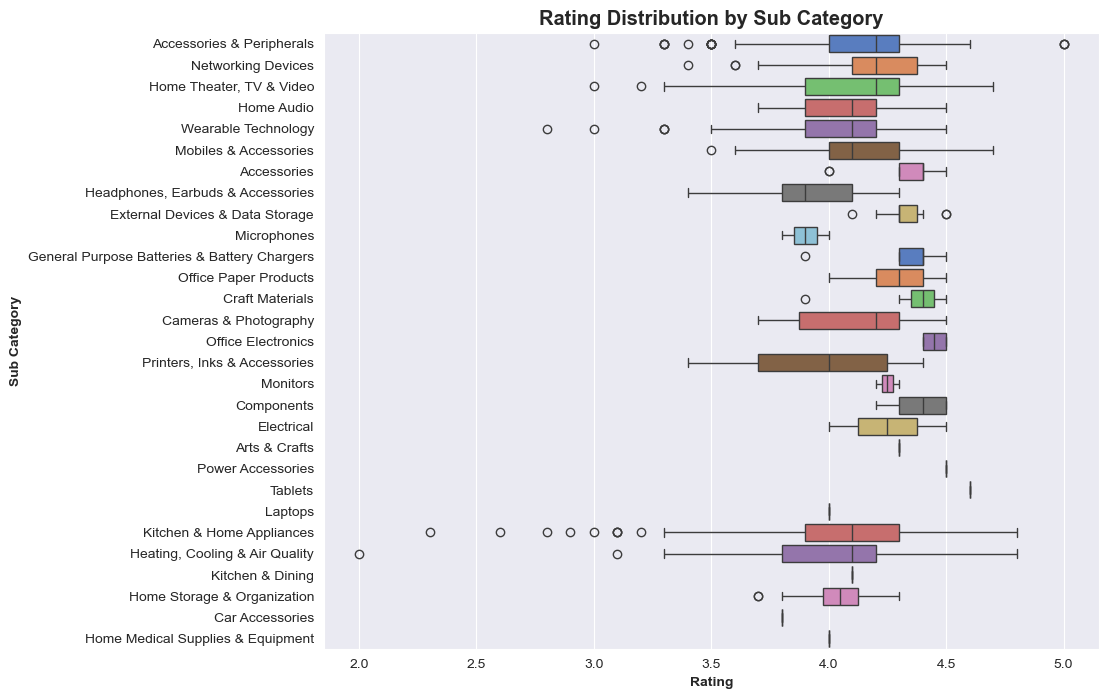

In [50]:
# Rating Distribution by Product Sub Category
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.boxplot(ax=ax, y='category_2', x='rating', data=df1, palette='muted')
ax.set_title('Rating Distribution by Sub Category', fontweight='bold', size='x-large')
ax.set_xlabel('Rating', fontweight='bold')
ax.set_ylabel('Sub Category', fontweight='bold')

plt.show()

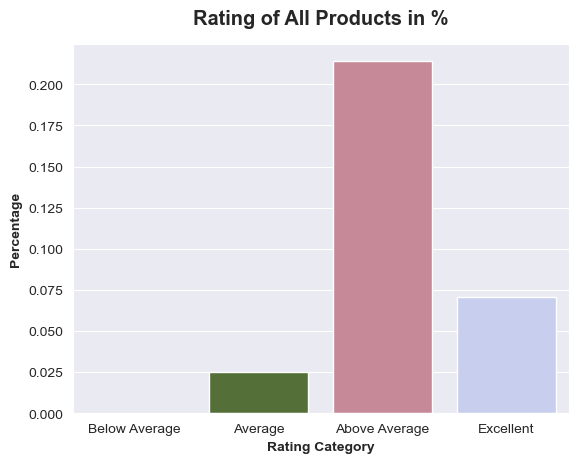

In [53]:
# Rating of all products in % 

rating_order = ['Below Average', 'Average', 'Above Average', 'Excellent']
rating_count = df1['rating_score'].value_counts(normalize=True).rename_axis('Rating').reset_index(name='counts')

rating_count['counts'] = rating_count['counts'].round(3)

rating_count_plot = sns.barplot(data=rating_count, x='Rating', y='counts', order=rating_order, palette='cubehelix')

rating_count_plot.set_title('Rating of All Products in %', fontweight='bold', size='x-large', y=1.03)
rating_count_plot.set_xlabel('Rating Category', fontweight='bold')
rating_count_plot.set_ylabel('Percentage', fontweight='bold')

rating_count_plot.bar_label(rating_count_plot.containers[0])

plt.show()

In [54]:
# Pivot table for Rating

def p_25(g):
    return np.percentile(g, 25)

def p_75(g):
    return np.percentile(g, 75)

rating_piv = df1.pivot_table(values=['rating', 'rating_count'], index=['category_1', 'category_2'], aggfunc={'rating': [np.mean, np.median, p_25, p_75], 'rating_count': [np.mean, np.median, p_25, p_75]})

rating_piv = rating_piv.rename(columns={'mean': 'Mean', 'median': 'Median', 'p_25': 'Q1', 'p_75': 'Q3'},
                               index={'category_1': 'Main Category', 'category_2': 'Sub Category'})

rating_piv

rating  \
                                                                          Mean   
category_1              category_2                                               
Car & Motorbike         Car Accessories                               3.800000   
Computers & Accessories Accessories & Peripherals                     4.148556   
                        Components                                    4.380000   
                        External Devices & Data Storage               4.316667   
                        Laptops                                       4.000000   
                        Monitors                                      4.250000   
                        Networking Devices                            4.155882   
                        Printers, Inks & Accessories                  3.963636   
                        Tablets                                       4.600000   
Electronics             Accessories                                   4.335714   
                        Cameras & Photography                         4.125000   
                        General Purpose Batteries & Battery Chargers  4.350000   
                        Headphones, Earbuds & Accessories             3.925758   
                        Home Audio                                    4.068750   
                        Home Theater, TV & Video                      4.075309   
                        Mobiles & Accessories                         4.127950   
                        Power Accessories                             4.500000   
                        Wearable Technology                           4.025000   
Health & PersonalCare   Home Medical Supplies & Equipment             4.000000   
Home & Kitchen          Craft Materials                               4.342857   
                        Heating, Cooling & Air Quality                3.990517   
                        Home Storage & Organization                   4.025000   
                        Kitchen & Dining                              4.100000   
                        Kitchen & Home Appliances                     4.052922   
Home Improvement        Electrical                                    4.250000   
Musical Instruments     Microphones                                   3.900000   
Office Products         Office Electronics                            4.450000   
                        Office Paper Products                         4.288889   
Toys & Games            Arts & Crafts                                 4.300000   

                                                                             \
                                                                     Median   
category_1              category_2                                            
Car & Motorbike         Car Accessories                                3.80   
Computers & Accessories Accessories & Peripherals                      4.20   
                        Components                                     4.40   
                        External Devices & Data Storage                4.30   
                        Laptops                                        4.00   
                        Monitors                                       4.25   
                        Networking Devices                             4.20   
                        Printers, Inks & Accessories                   4.00   
                        Tablets                                        4.60   
Electronics             Accessories                                    4.40   
                        Cameras & Photography                          4.20   
                        General Purpose Batteries & Battery Chargers   4.40   
                        Headphones, Earbuds & Accessories              3.90   
                        Home Audio                                     4.10   
                        Home Theater, TV & Video                       4.20   
                        M